In [1]:
import gzip, json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def combine_results(*jsons):
    jsons0 = []
    for js in zip(*jsons):
        j0 = {}
        for j in js:
            for k, v in j.items():
                j0[k] = v
        jsons0.append(j0)
    return jsons0

def parse_file(filename):
    with gzip.open(filename, "rb") as f:
        lines = f.readlines()
        return [json.loads(line) for line in lines]

In [3]:
jsons1101_2s = parse_file("../results/rob200-depth8-time2-100:200-1101.gz") # Merge's results are invalid in this one
jsons0100_2s = parse_file("../results/rob200-depth8-time2-100:200-0100.gz")
jsons1101_2s = combine_results(jsons1101_2s, jsons0100_2s)
jsons1100_4s = parse_file("../results/rob200-depth8-time4-100:200-1100.gz")
jsons1100_6s = parse_file("../results/rob200-depth8-time6-100:200-1100.gz")
jsons1100_8s = parse_file("../results/rob200-depth8-time8-100:200-1100.gz")
jsons1100_10s = parse_file("../results/rob200-depth8-time10-100:200-1100.gz")

jsons0e00 = parse_file("../results/rob200-depth8-100:200-0e00.gz") # external merge (clique size 2, merge level 2, anything more is OOM)

In [4]:
jsons0e00_start40 = parse_file("../results/rob_start40_200-depth8-100:200-0e00.gz") # external merge (clique size 2, merge level 2, anything more is OOM)

In [5]:
kan_deltas = np.array([j["kantchelian_delta"] for j in jsons1101_2s])
kan_times = np.array([j["kantchelian"]["time_p"] for j in jsons1101_2s])

mext_deltas = np.array([j["merge_ext"]["deltas"][-1] for j in jsons0e00])
mext_times = np.array([j["merge_ext"]["times"][-1] for j in jsons0e00])

In [18]:
jsons_dict = {2: jsons1101_2s, 4: jsons1100_4s, 6: jsons1100_6s, 8: jsons1100_8s, 10: jsons1100_10s}
mer_times = {}
mer_deltas = {}
ver1_times = {}
ver1_deltas = {}
ver2_times = {}
ver2_deltas = {}
for seconds, jsons in jsons_dict.items():
    mer_times[seconds] = np.array([j["merge_time"] for j in jsons])
    mer_deltas[seconds] = np.array([j["merge_deltas"][-1][0] for j in jsons])
    ver1_times[seconds] = np.array([j["veritas_time"] for j in jsons])
    ver1_deltas[seconds] = np.array([j["veritas_deltas"][-1][1] for j in jsons])
    ver2_times[seconds] = np.array([j["veritas_ara_time"] for j in jsons])
    ver2_deltas[seconds] = np.array([j["veritas_ara_deltas"][-1][1] for j in jsons])

# Bound when given more or less time

In [19]:
mer_ts = [t.mean() for t in mer_times.values()]
mer_ys = [np.abs(d-kan_deltas).mean() for d in mer_deltas.values()]
ver1_ts = [t.mean() for t in ver1_times.values()]
ver1_ys = [np.abs(d-kan_deltas).mean() for d in ver1_deltas.values()]
ver2_ts = [t.mean() for t in ver2_times.values()]
ver2_ys = [np.abs(d-kan_deltas).mean() for d in ver2_deltas.values()]
mext_t = mext_times.mean()
mext_y = np.abs(mext_deltas-kan_deltas).mean()
kan_t = kan_times.mean()

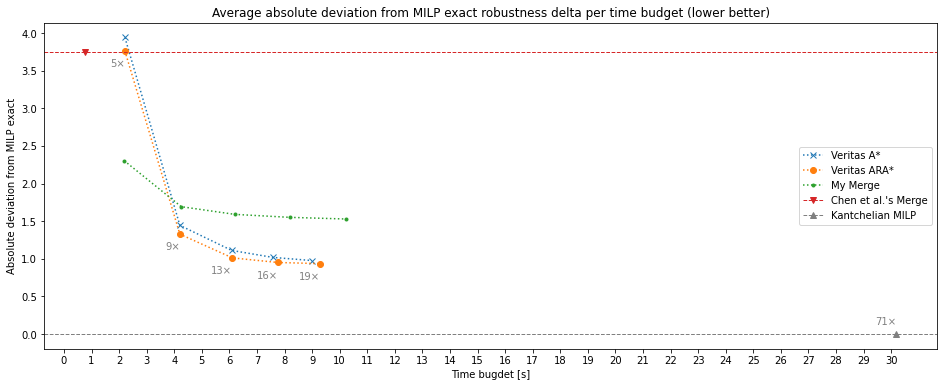

In [20]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_title("Average absolute deviation from MILP exact robustness delta per time budget (lower better)")
ax.plot(ver1_ts, ver1_ys, "x:", label="Veritas A*")
ax.plot(ver2_ts, ver2_ys, "o:", label="Veritas ARA*")
for i, (x, y) in enumerate(zip(ver2_ts, ver2_ys)):
    ax.text(x, y-0.1, f"{M[4,i]:.0f}×", horizontalalignment='right', verticalalignment='top', c="gray")
ax.plot(mer_ts, mer_ys, ".:", label="My Merge")
ax.set_xlabel("Time bugdet [s]")
ax.set_ylabel("Absolute deviation from MILP exact")
l, = ax.plot([mext_t], [mext_y], "v--", lw=1, label="Chen et al.'s Merge")
ax.axhline(y=mext_y, ls=l.get_linestyle(), c=l.get_color(), lw=l.get_linewidth())
l, = ax.plot([kan_t], [0.0], "^--", lw=1, c="gray", label="Kantchelian MILP")
ax.axhline(y=0.0, ls=l.get_linestyle(), c=l.get_color(), lw=l.get_linewidth())
ax.text(kan_t, 0.1, f"{kan_slower_mext:.0f}×", horizontalalignment='right', verticalalignment='bottom', c="gray")
ax.set_xticks(range(0, 31))
ax.legend()
plt.show()

# How often better than Chen / as good as Kantchelian MILP

In [21]:
mext_ad = np.abs(mext_deltas-kan_deltas)
same_threshold = 0.1
f = 100.0 / len(mext_ad) # as percentage

mer_ts = [t.mean() for t in mer_times.values()]
mer_ys = [f*np.sum(mext_ad - np.abs(d-kan_deltas) > same_threshold) for d in mer_deltas.values()]
ver1_ts = [t.mean() for t in ver1_times.values()]
ver1_ys = [f*np.sum(mext_ad - np.abs(d-kan_deltas) > same_threshold) for d in ver1_deltas.values()]
ver2_ts = [t.mean() for t in ver2_times.values()]
ver2_ys = [f*np.sum(mext_ad - np.abs(d-kan_deltas) > same_threshold) for d in ver2_deltas.values()]

mer_ysb = [f*np.sum(np.abs(d-kan_deltas)-mext_ad > same_threshold) for d in mer_deltas.values()]
ver1_ysb = [f*np.sum(np.abs(d-kan_deltas)-mext_ad > same_threshold) for d in ver1_deltas.values()]
ver2_ysb = [f*np.sum(np.abs(d-kan_deltas)-mext_ad > same_threshold) for d in ver2_deltas.values()]

mer_ys2 = [f*np.sum(same_threshold > np.abs(d-kan_deltas)) for d in mer_deltas.values()]
ver1_ys2 = [f*np.sum(same_threshold > np.abs(d-kan_deltas)) for d in ver1_deltas.values()]
ver2_ys2 = [f*np.sum(same_threshold > np.abs(d-kan_deltas)) for d in ver2_deltas.values()]
mext_y2 = f*np.sum(same_threshold > np.abs(mext_deltas-kan_deltas))

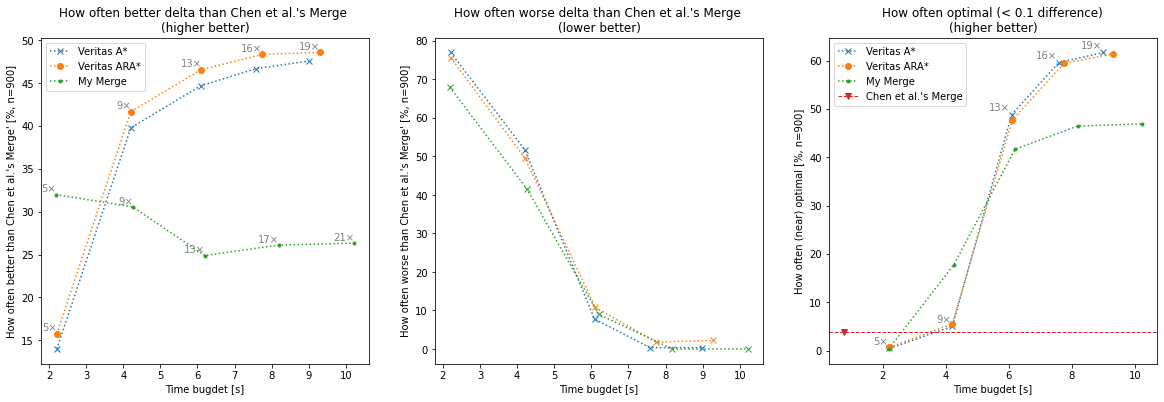

In [22]:
fig, (ax1, ax3, ax2) = plt.subplots(1, 3, figsize=(20, 6))
ax1.set_title("How often better delta than Chen et al.'s Merge \n(higher better)")
ax3.set_title("How often worse delta than Chen et al.'s Merge \n(lower better)")
l, = ax1.plot(ver1_ts, ver1_ys, "x:", label="Veritas A*")
ax3.plot(ver1_ts, ver1_ysb, "x:", c=l.get_color())

l, = ax1.plot(ver2_ts, ver2_ys, "o:", label="Veritas ARA*")
ax3.plot(ver2_ts, ver2_ysb, "x:", c=l.get_color())

for i, (x, y) in enumerate(zip(ver2_ts, ver2_ys)):
    ax1.text(x, y+0.1, f"{M[4,i]:.0f}×", horizontalalignment='right', verticalalignment='bottom', c="gray")
l, = ax1.plot(mer_ts, mer_ys, ".:", label="My Merge")
ax3.plot(mer_ts, mer_ysb, "x:", c=l.get_color())
for i, (x, y) in enumerate(zip(mer_ts, mer_ys)):
    ax1.text(x, y+0.1, f"{M[5,i]:.0f}×", horizontalalignment='right', verticalalignment='bottom', c="gray")
ax1.set_xlabel("Time bugdet [s]")
ax1.set_ylabel(f"How often better than Chen et al.'s Merge' [%, n={len(mext_ad)}]")
ax3.set_xlabel("Time bugdet [s]")
ax3.set_ylabel(f"How often worse than Chen et al.'s Merge' [%, n={len(mext_ad)}]")
ax1.legend()

ax2.set_title(f"How often optimal (< {same_threshold} difference)\n(higher better)")
ax2.plot(ver1_ts, ver1_ys2, "x:", label="Veritas A*")
ax2.plot(ver2_ts, ver2_ys2, "o:", label="Veritas ARA*")
for i, (x, y) in enumerate(zip(ver1_ts, ver1_ys2)):
    ax2.text(x-0.05, y+0.5, f"{M[3,i]:.0f}×", horizontalalignment='right', verticalalignment='bottom', c="gray")
ax2.plot(mer_ts, mer_ys2, ".:", label="My Merge")
l, = ax2.plot([mext_t], [mext_y], "v--", lw=1, label="Chen et al.'s Merge")
ax2.axhline(y=mext_y, ls=l.get_linestyle(), c=l.get_color(), lw=l.get_linewidth())
ax2.set_xlabel("Time bugdet [s]")
ax2.set_ylabel(f"How often (near) optimal [%, n={len(mext_ad)}]")
ax2.legend()

plt.show()

# Slower wrt Chen et al.'s Merge / MILP

In [23]:
mer_ys = [np.mean(t/mext_times) for t in mer_times.values()]
ver1_ys = [np.mean(t/mext_times) for t in ver1_times.values()]
ver2_ys = [np.mean(t/mext_times) for t in ver2_times.values()]

M = np.zeros((6, 5))
M[0,:] = [np.mean(t) for t in ver1_times.values()]
M[1,:] = [np.mean(t) for t in ver2_times.values()]
M[2,:] = [np.mean(t) for t in mer_times.values()]
M[3,:] = ver1_ys
M[4,:] = ver2_ys
M[5,:] = mer_ys

kan_slower_mext = np.mean(kan_times/mext_times)

mean Chen et al.'s Merge:  0.76 seconds
Kantchelian MILP:          71.0 x

mean times [seconds]
[[ 2.21  4.2   6.09  7.58  9.  ]
 [ 2.21  4.2   6.11  7.75  9.29]
 [ 2.18  4.26  6.2   8.19 10.23]]
how much slower than Chen et al.'s Merge [times slower than...]
[[ 4.6  8.8 12.7 15.7 18.7]
 [ 4.6  8.8 12.7 16.2 19.4]
 [ 4.5  8.9 12.9 17.1 21.4]]


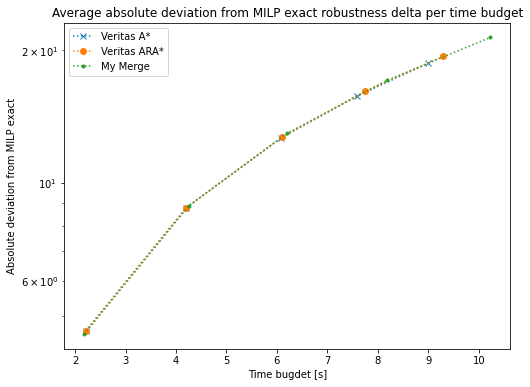

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Average absolute deviation from MILP exact robustness delta per time budget")
ax.semilogy(ver1_ts, ver1_ys, "x:", label="Veritas A*")
ax.semilogy(ver2_ts, ver2_ys, "o:", label="Veritas ARA*")
ax.semilogy(mer_ts, mer_ys, ".:", label="My Merge")
ax.set_xlabel("Time bugdet [s]")
ax.set_ylabel("Absolute deviation from MILP exact")
ax.legend()
print("mean Chen et al.'s Merge: ", np.round(np.mean(mext_times), 2), "seconds")
print("Kantchelian MILP:         ", np.round(kan_slower_mext, 1), "x")
print()
print("mean times [seconds]")
print(M[0:3,:].round(2))
print("how much slower than Chen et al.'s Merge [times slower than...]")
print(M[3:,:].round(1))
plt.show()

In [17]:
display("num_errors", sum(x["merge_ext"]["exc"] for x in jsons0e00_start40))
display("ad delta", np.mean(list(np.abs(k-x["merge_ext"]["deltas"][-1]) for k, x in zip(kan_deltas, jsons0e00_start40) if not x["merge_ext"]["exc"])))
np.mean(list(x["merge_ext"]["times"][-1] for x in jsons0e00_start40 if not x["merge_ext"]["exc"]))

'num_errors'

25

'ad delta'

3.0717370328103715

2.0545944971428574